In [1]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import warnings
from PIL import Image
import re
import squarify
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

# Getting the data ready for Classification
Here, the group name responsible for the attack is to be predicted. So lets just get a quick look how many classes we have and what is their distribution

In [423]:
mask = np.array(Image.open("C:/Users/Kavan/Desktop/1.png"))
data = pd.read_csv("C:/Users/Kavan/Desktop/GTD/globalterrorismdb_0617dist.csv",encoding='ISO-8859-1')

In [4]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN


In [7]:
len(data['gname'].unique())

3453

As you can see, there are 3,453 unique classes i.e., different terrorist groups in the dataset. It is very difficult task to plot its histogram and visualize. Rather lets sample it and try to see if we get any idea about the distribution of classes in dataset.

The dataset contains a huge number of "Unknown"s in Group Name.

In [362]:
len(data[data['gname']=="Unknown"])/len(data)*100

45.96771353096566

These rows should be removed due to two reasons:
1.) They have a huge proportion in dataset
2.) Learning them doesn't make any sense.

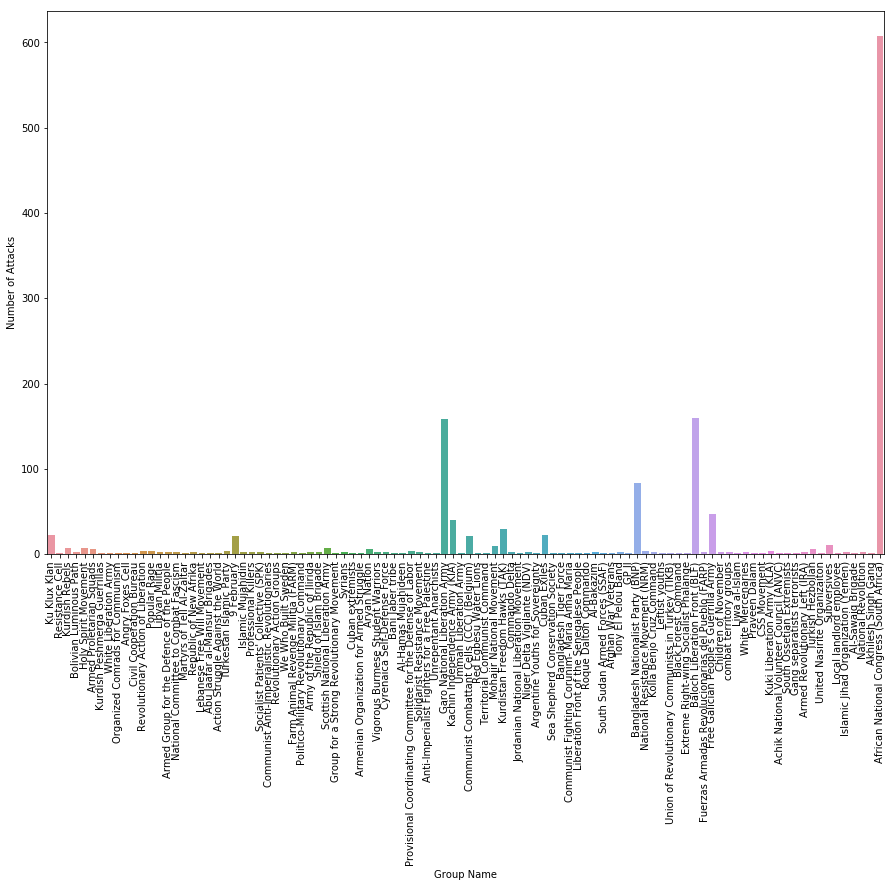

In [261]:
plt.subplots(figsize=(15,10))
no_of_classes = data['gname'].value_counts(sort=True)
no_of_classes_sample = no_of_classes.sample(n=100)
p = sns.barplot(no_of_classes_sample.index,no_of_classes_sample)
p.set(xlabel="Group Name",ylabel="Number of Attacks")
p.set_xticklabels(no_of_classes_sample.index,rotation=90)
plt.show()

The distribution of classes is highly skewed. There are many classes that only appear once in entire data (These are outliers). They need to be removed as the learning algorithm won't be able to learn it. There are many classes to remove, but how to decide which to remove and which not. Well, lets decide a threshold value of "number of occurrence" of a class. Example threshold = 200, any class having number of occurances less than class_freq[threshold] will be removed. (We can increase or decrease this value according to need, ofcourse prediciton value will differ in each case. Increasing threshold will increase score because there are not many outliers and as we decrease it more and more outliers are addded in the data as they have not many instances sufficent enough to learn)
The value of threshold can be anything, for now lets choose 50.

Above value of threshold will be used in the prediction model.

In [235]:
threshold = 500
class_freq = data[data['gname']!='Unknown']['gname'].value_counts()
class_freq[threshold]

11

Below function takes "threshold" value as parameter and filters out the classes having frequency less than class_freq[threshold]. The model doesn't expectes all the attributes given in data. It takes following attributes: iyear, imonth, iday, extended, country, region, latitude, longitude, vicinity, crit1 , crit2, crit3(the model doesn't uses these 3 variables, but it uses to filter out data), doubtterr, attacktype1, targtype1, weaptype1  

The rows having crit1, crit2 and crit3 != 1 are removed because we are looking for attacks that match requirements as "terrorist attacks". The function then randomizes the data and splits into groups of train and test.

In [425]:
data = data[data['gname']!='Unknown']# Remove "Unknown" groups, they contribut more than

In [428]:
def prep(data,threshold):
    l = LabelEncoder()
    a = data[data['gname']!='Unknown']['gname'].value_counts()  # Count frequency of each groups
    data['weaptype1_txt'] = data['weaptype1_txt'].apply(lambda x: 'Vehicle' if x=='Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)' else x)
    data2 = data[data['gname']!='Unknown'] # Remove "Unknown" groups, they contribut more than
    data2['provstate'] = data2.apply(lambda row: row['city'] if pd.isnull(row['provstate']) else row['provstate'], axis=1)
    data3 = data2.loc[:,data2.columns[[1,2,3,5,7,9,11,13,14,16,19,20,21,22,28,34,58,81]]] #Select only intereseted columns
    data3 = data3[(data3.crit1==1) & (data3.crit2==1) & (data3.crit3 ==1) & (data3.doubtterr==0)] #Keep rows that are terrorist attacks for sure
    data3 = data3[data3['gname'].isin(a.index[:threshold])] #Remove classes having frequency less than class_frequency[threshold]
    data3 = data3.sample(frac=1) #Randomize dataset
    data3 = data3.dropna() 
    data3['provstate'] = l.fit_transform(data3['provstate'])
    data3['gname'] = l.fit_transform(data3['gname'])
    y = data3['gname']
    data3 = data3.drop('gname',axis=1)
    train = data3[:round(0.85*len(data3))]
    y_train = y[:round(0.85*len(data3))]
    test = data3[round(0.85*len(data3)):]
    y_test = y[round(0.85*len(data3)):]
    return train, y_train, test, y_test

In [430]:
train, y_train, test, y_test = prep(data,threshold)

# Exploratory Data Analysis

Lets get the idea about the text data we have, as you can see the most of the addnotes have words "casualty", "conflict", "attakck", "victims"

In [38]:
# Show a word-cloud
text = data['addnotes']
def get_wordcloud(text):
    text = text.dropna()
    text = text.to_string()
    text = re.sub(' +',' ',text)
    wordcloud = WordCloud(mask = mask).generate(text)
    plt.figure()
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0,y=0)
    plt.show()

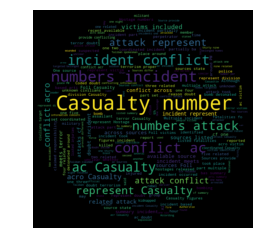

In [39]:
get_wordcloud(text)

Lets have a look at World Map that shows number of attacks for year 2016

In [ ]:
d = data[data['iyear']==2016]
d2 = pd.DataFrame(d.groupby(['country_txt'])['country_txt'].count())
d2.columns = ['count']
d2.reset_index(inplace=True)
world_geo = r'C:/Users/Kavan/Desktop/New folder/world.json'
m = folium.Map(location=[20,0],zoom_start=2)
m.choropleth(world_geo,name='choropleth',
             data=d2,columns=['country_txt','count'],
             key_on='feature.properties.name',
             fill_color = 'Reds',
             threshold_scale =[1,200,500,800,1200,1400],
             legend_name ="Number of Attacks in each country")
folium.LayerControl().add_to(m)
#Saved the folium html file as png and displayed on Jupyter Notebook

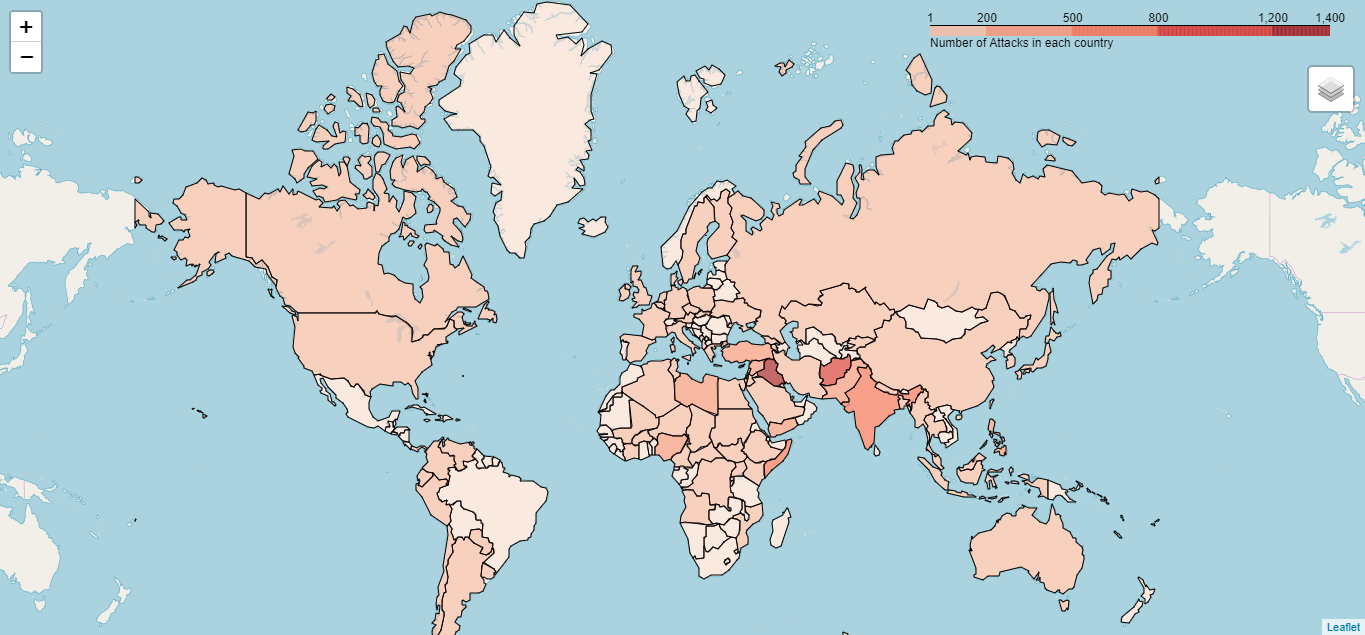

In [511]:
from IPython.display import Image
Image("C:/Users/Kavan/Desktop/map.png")

Number of kills from 1970 to 2016 by terrorist attacks globally.

It can be seen from below graph that number of kills in 2001 was significantly higher than its left and right neighbours. It is because about 3000 deaths have been reported during the attacks of 9/11. The number decreases after that maybe because of decreasing terrorist activity due to subsequent measures taken by U.S. government and rest of the world. It rose during second decade of 21st century due to birth of infamous terrorist groups like ISIS, ISIL, Taliban etc.

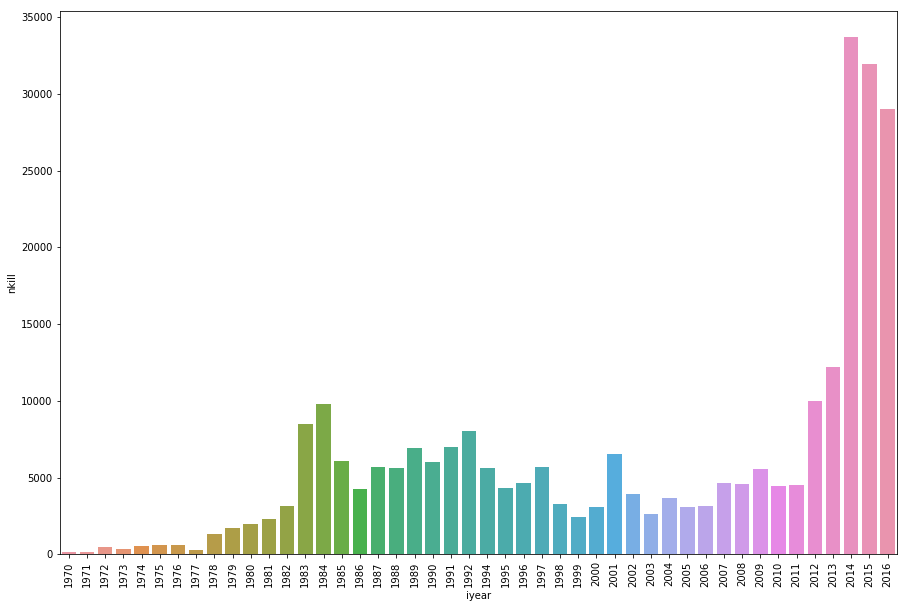

In [68]:
data['nkill'].fillna(0)
no_of_kills = data.groupby('iyear')['nkill'].sum()
plt.subplots(figsize=(15,10))
plot1 = sns.barplot(no_of_kills.index,no_of_kills)
plot1.set_xticklabels(no_of_kills.index,rotation=90)
plt.show()

Above insight can be verified by below graph, which shows the number of kills in Middle East region. It has been growing ever since 2010 i.e., during increasing conflicts in Syria, "2011 March - Security forces shoot dead protestors in southern city of Deraa demanding release of political prisoners, triggering violent unrest that steadily spread nationwide over the following months." (https://www.bbc.com/news/world-middle-east-14703995)

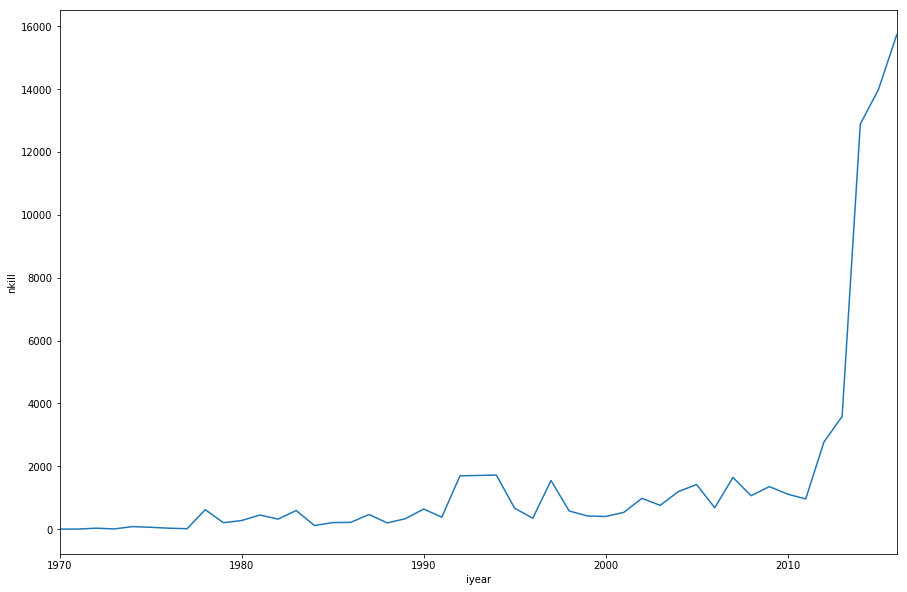

In [78]:
plt.subplots(figsize=(15,10))
d = data[data['region_txt']=='Middle East & North Africa']
d3 = pd.DataFrame(d.groupby(['iyear'])['nkill'].sum())
d3.reset_index(inplace=True)
d3['dummy']=0
l = sns.tsplot(time="iyear",value="nkill",data=d3,unit="dummy")
plt.show(l)

Average Number of kills each month.

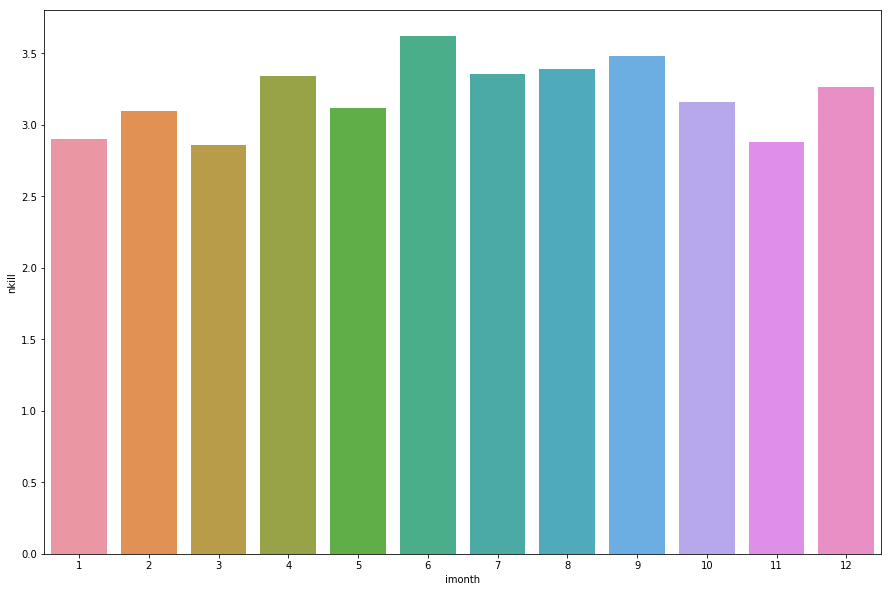

In [64]:
plt.subplots(figsize=(15,10))
kills_month = data.groupby('imonth')['nkill'].mean().iloc[1:]
plot2 = sns.barplot(kills_month.index,kills_month)
plt.show()

Total number of attacks every year by region

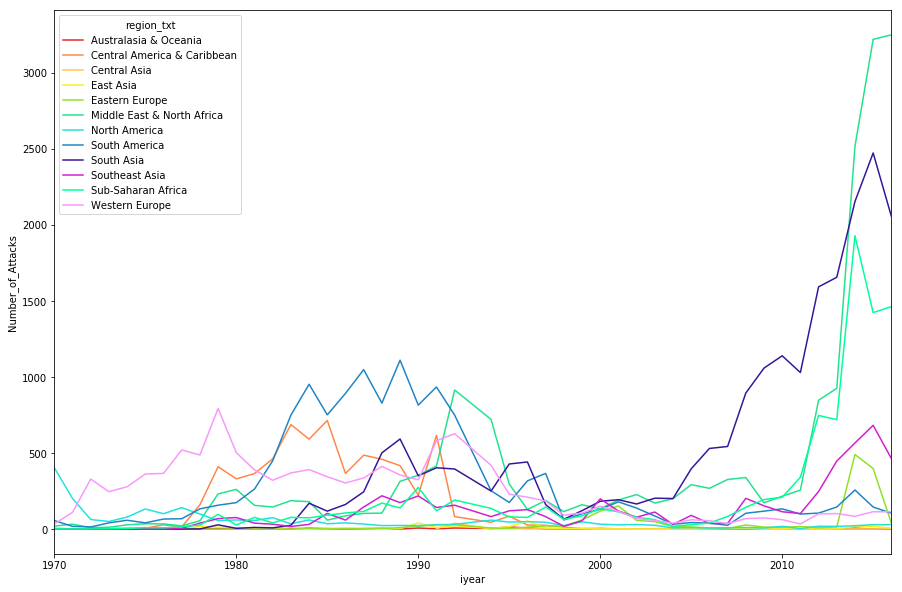

In [262]:
plt.subplots(figsize=(15,10))
d = data.groupby(['region_txt','iyear'])['iyear'].count()
d = pd.DataFrame(d)
d.reset_index(level=0,inplace=True)
d.columns = ['region_txt','Number_of_Attacks']
d.reset_index(level=0,inplace=True)
d['dummy']=0
color_set = ["#e82727","#ff8649","#ffc549","#fced20","#8fe222","#22e28e","#22e2db","#1f85c4","#361599","#d11fce","#00ff99","#fa97fc"]
sns.tsplot(time='iyear',value='Number_of_Attacks',condition='region_txt',data=d,unit='dummy',color = sns.color_palette(color_set))
plt.show()

Activity of top 10 most infamous terrorist groups.

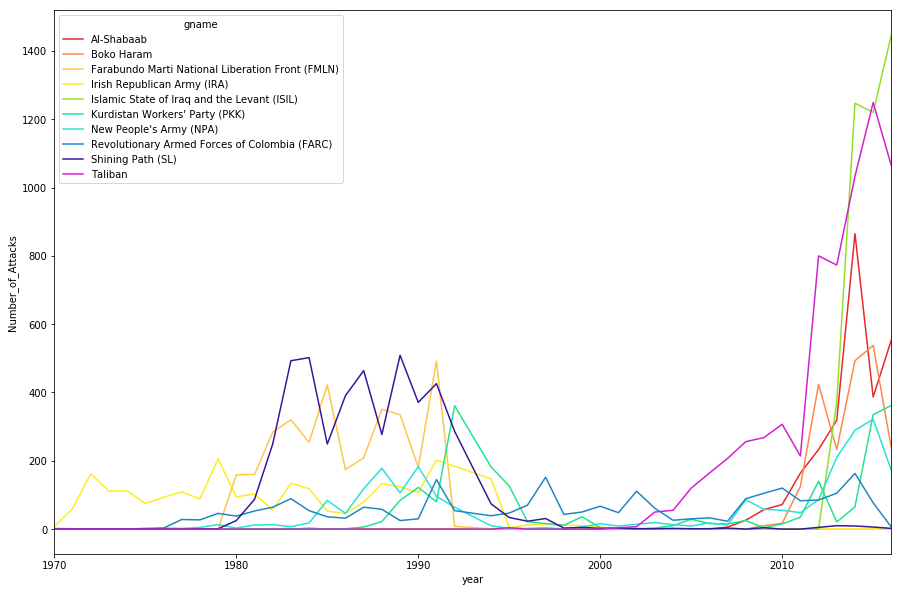

In [432]:
plt.subplots(figsize=(15,10))
d = pd.DataFrame(data.groupby(['gname','iyear'])['iyear'].count())
d.columns=['Number_of_Attacks']
d.reset_index(inplace=True)
d2 = d.loc[d['gname'].isin(data['gname'].value_counts().sort_values(ascending=False).index[:10])]
d2 = d2.pivot(index='gname',columns='iyear',values='Number_of_Attacks').fillna(0)
d2 = pd.DataFrame(d2.unstack(level=0))
d2.reset_index(inplace=True)
d2.columns=['year','gname','Number_of_Attacks']
color_set = ["#e82727","#ff8649","#ffc549","#fced20","#8fe222","#22e28e","#22e2db","#1f85c4","#361599","#d11fce"]
d2['dummy']=0
sns.tsplot(time='year',value='Number_of_Attacks',condition='gname',data=d2,unit='dummy',color = sns.color_palette(color_set))
plt.show()

In [440]:
d2.head()

,year,gname,Number_of_Attacks,dummy
0,1970,Al-Shabaab,0.0,0
1,1970,Boko Haram,0.0,0
2,1970,Farabundo Marti National Liberation Front (FMLN),0.0,0
3,1970,Irish Republican Army (IRA),7.0,0
4,1970,Islamic State of Iraq and the Levant (ISIL),0.0,0


Below graph shows number of death every month for United States. It can be seen clearly the attacks of 9/11

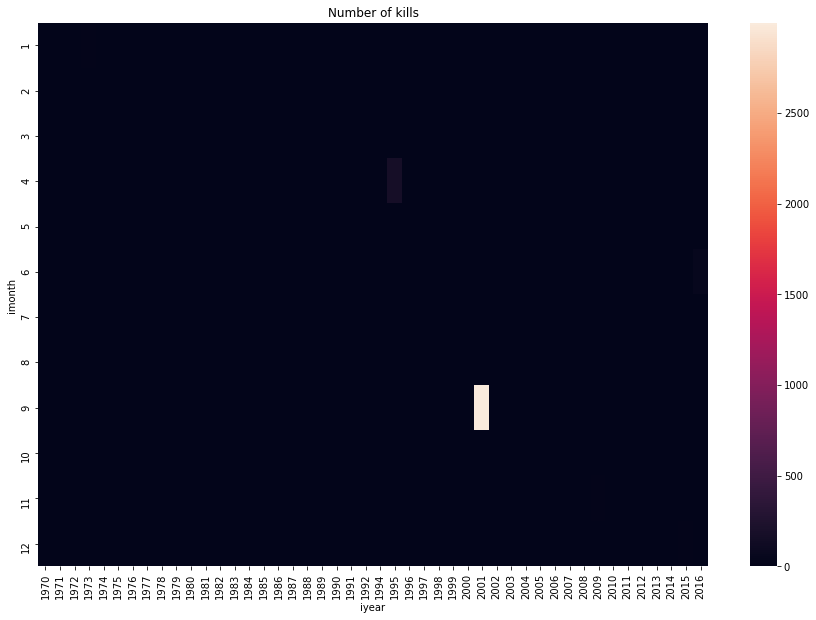

In [200]:
plt.subplots(figsize=(15,10))
d = data[data['country_txt']=="United States"]
d2 = d.groupby(['iyear','imonth'])['nkill'].sum()
d2 = pd.DataFrame(d2)
d2 = d2.fillna(0)
d2.columns = ['count']
d2.reset_index(inplace=True)
d2 = d2.pivot("imonth","iyear","count")
d2 = d2.fillna(0)
sns.heatmap(d2).set_title("Number of kills")
plt.show()

Which weapon type is Taliban's most favorite?

In [299]:
gname = "Taliban"
def treeplot(data,gname):
    plt.subplots(figsize=(15,10))
    w_t = pd.DataFrame(data[data['gname']==gname]['weaptype1_txt'].value_counts())
    w_t.reset_index(level=0,inplace=True)
    t = squarify.plot(sizes=w_t["weaptype1_txt"],label=w_t["index"],alpha=0.8)
    plt.show()

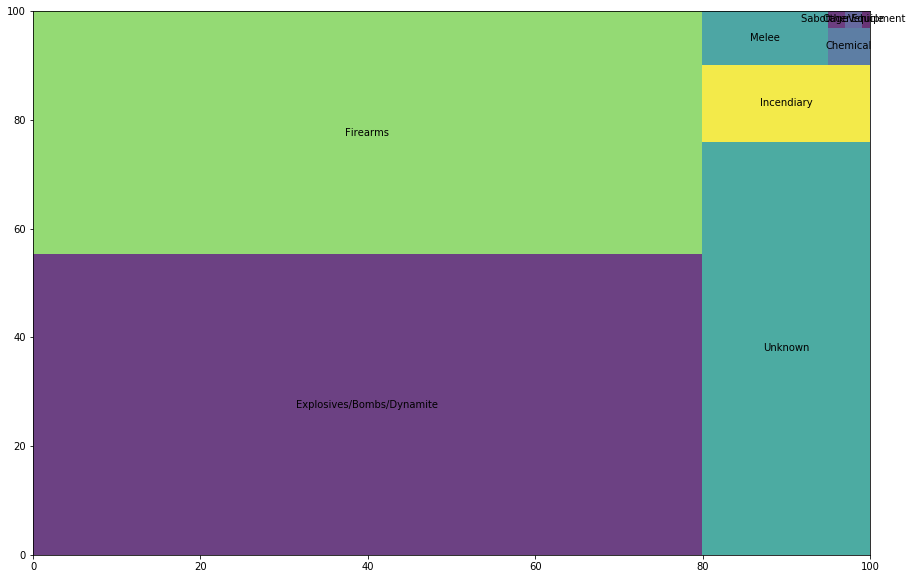

In [354]:
treeplot(data,"Taliban")

For year 2016, more than 75% of terrorist attacks happened within just 10 countries : Iraq, Afghanistan, India, Somalia, Turky, Yemen, Nigeria, Syria, Philippines and Pakistan. Rest of the world combined had less than 25% of total global terrorist attacks. 

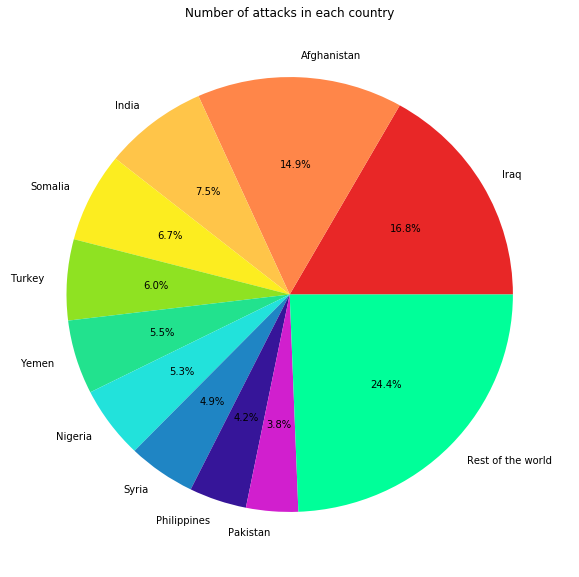

In [201]:
plt.subplots(figsize=(10,10))
d = pd.DataFrame(data[data['iyear']==2016]['country_txt'].value_counts(sort=True)[:10])
d.reset_index(inplace=True)
d.columns=['country','no_of_attacks']
append = ['Rest of the world',sum(data[data['iyear']==2016]['country_txt'].value_counts(sort=True)) - sum(data[data['iyear']==2016]['country_txt'].value_counts(sort=True)[:10])]
d.loc[len(d)]= append
color_set = ["#e82727","#ff8649","#ffc549","#fced20","#8fe222","#22e28e","#22e2db","#1f85c4","#361599","#d11fce","#00ff99","#fa97fc"]
plt.title("Number of attacks in each country")
plt.pie(d['no_of_attacks'],labels=d['country'],colors= color_set,autopct='%.1f%%')
plt.show()


For year 2016, more than 86% of deaths due to terrorist attacks occured within 10 countries : Iraq, Afghanistan, Syria, Nigeria, Somalia, Yemen, Turkey, Pakistan, South Sudan, Libya. Rest of the world combined had less than 14% of deaths. 

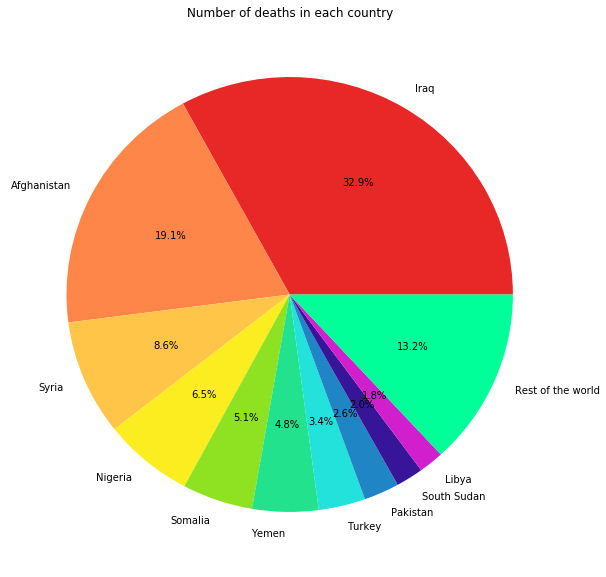

In [202]:
plt.subplots(figsize=(10,10))
d = data[data['iyear']==2016]
d2 = pd.DataFrame(d.groupby('country_txt')['nkill'].sum().sort_values(ascending=False)[:10])
d2.reset_index(inplace=True)
append = ['Rest of the world',(d['nkill'].sum()- d2['nkill'].sum())]
d2.loc[len(d2)] = append
color_set = ["#e82727","#ff8649","#ffc549","#fced20","#8fe222","#22e28e","#22e2db","#1f85c4","#361599","#d11fce","#00ff99","#fa97fc"]
plt.title("Number of deaths in each country")
plt.pie(d2['nkill'],labels=d2['country_txt'],colors= color_set,autopct='%.1f%%')
plt.show()

Now below is the bar graph of number of attacks for top 10 countries for year 2016. The graph shows us that Iraq is the most dangerous country to live in, then comes Afghanistan, India, Somalia, Turkey and rest. Well this graph is kind of misleading if we want to decide "most dangerous country". And by "most dangerous country" we have to decide a particular metric for "dangerous". That ofcourse can't be number of attacks. In other words we have to define what do we mean by "most dangerous" in terms of data.

It is like to decide out of given two boxes, one contains wood and other cotton, which is heavy. Ofcourse wood is heavy than cotton but here we dont consider dimensions of given boxes like volume or area. If we have information like 1000 cubic meter of cotton and 1 cubic meter of wood, than we can decide which one is heavy. Beacause we assigned a metric of Volume for "heavyness" of a box. 

Similarly, to find out most dangerous country, we have to find number of attacks per 1000 people or 1,000,000 people beacuse thats more accurate metric for "most dangerous".

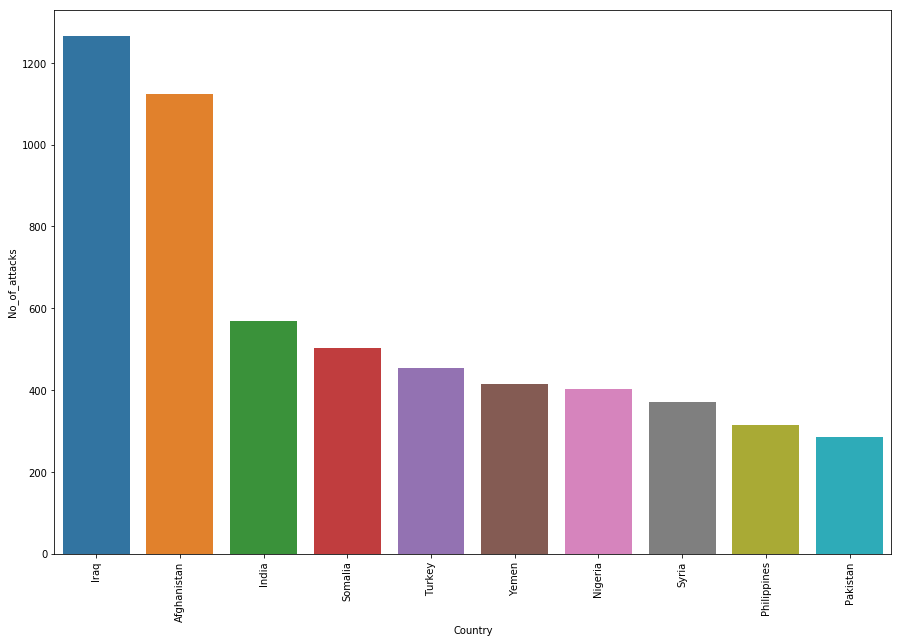

In [268]:
plt.subplots(figsize=(15,10))
d = data[data['iyear']==2016]
countries = pd.DataFrame(d['country_txt'].value_counts()[:10])
countries.reset_index(inplace=True)
countries.columns= ['Country','No_of_attacks']
population = pd.Series([37202572,34656032,1324171354, 14317996, 79512426, 27584213, 20672987, 18430453, 103320222, 193203476])
countries2 = copy.deepcopy(countries)
countries['No_of_attacks'] = countries['No_of_attacks']/population*1000000
p1 = sns.barplot(countries2['Country'],countries2['No_of_attacks'],data= countries2)
p1.set_xticklabels(countries2['Country'],rotation=90)
plt.show(p1)

Now below is the graph that shows the most dangerous country in 2016. Here is the link to a blog (http://www.businessinsider.com/most-dangerous-countries-in-the-world-2016-6) by Business Insider and it shows 15 most dangerous countries. They have compared each country by peace index, unlike this notebook which only takes terrorism into account. But though results are pretty much same.
So with below graph one can say that "Probability to die by terrorist attack" is highest in Somalia and least in India if you spawn in any of below 10 countries. 

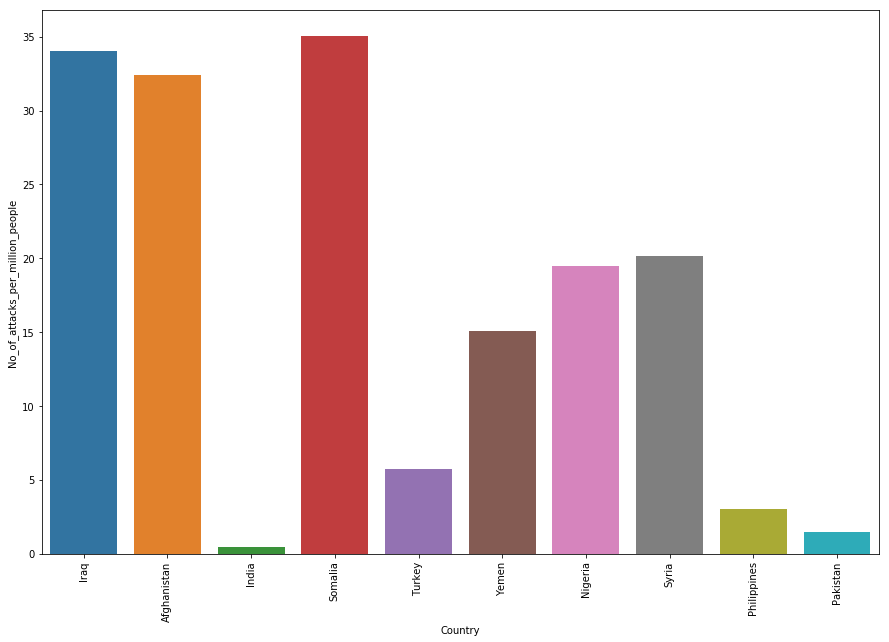

In [269]:
plt.subplots(figsize=(15,10))
countries.columns = ['Country','No_of_attacks_per_million_people']
p2 = sns.barplot(countries['Country'],countries['No_of_attacks_per_million_people'],data= countries)
p2.set_xticklabels(countries['Country'],rotation=90)
plt.show()

Lets try to analyse above graph in depth.

In [484]:
def succ_fail(data,country):
    s = data[data['country_txt']==country]
    s2 = pd.DataFrame(s.groupby(['iyear','success'])['iyear'].count())
    s2.columns=['count']
    s2.reset_index(inplace=True)
    s2["dummy"]=0
    color_set2 = ['#f71325','#20d813']
    sns.tsplot(time='iyear',value='count',condition='success',data=s2,unit='dummy',color = sns.color_palette(color_set2)).set_title(country)
    plt.show()
    #print (s2.head())

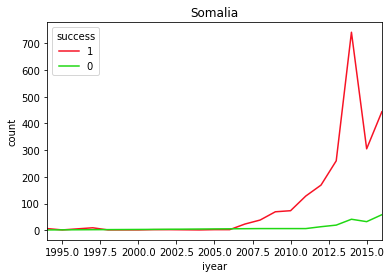

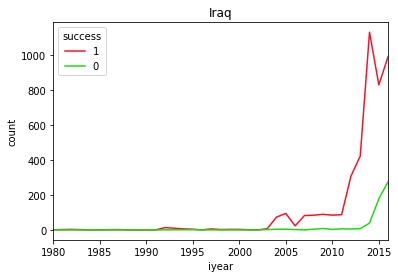

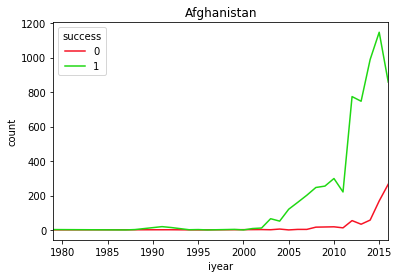

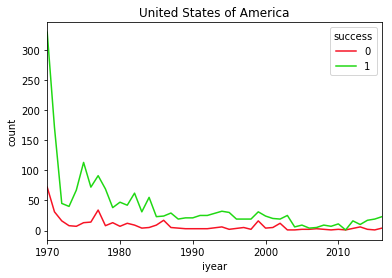

In [487]:
succ_fail(data, "Somalia")
succ_fail(data,"Iraq")
succ_fail(data, "Afghanistan")
succ_fail(data, "United States of America")

From above graph, it looks like United States of America have been most successfull in forfeiting terrorist attacks, whereas countries like Sudan, Bangladesh, Somalia have failed. Which might be the reason for high values of "attacks per million" for such countries. (One thing to be noted is line colors are flipped for US, beacause the API assigns first color to the value it sees first in the dataframe, either 1 or 0.)

# Prediction of groups responsible for the attack 
Here we have a multi-class classification problem. So f1 score is used as an evaluation metric with micro average. The dataset is highly skewed in terms of number of classes. So "macro average" will be a biased score as it is just average of individual Precision and Recall scores for each class, i.e., for classes with high frequency will have higher scores as compared to other classes which results in biased overall score.

Whereas with micro averaged score, the performance (Precision or Recall) is calculated from individual True Positive, True Negative, False Positive, False Negative. This elimintaes the biasness of performance scores by classes with high frequency.

In [129]:
rf = RandomForestClassifier(n_estimators=50)
tree = DecisionTreeClassifier(criterion="entropy")
gbm = GradientBoostingClassifier(learning_rate=0.2, max_depth=8)
def predict(model,train,y_train,test,y_test):
    model.fit(train,y_train)
    yhat = model.predict(test)
    return f1_score(y_test,yhat,average='micro')

In [242]:
print ("We removed ",round((sum(class_freq) - sum(class_freq[:threshold]))/sum(class_freq)*100,2),"% of data as outliers. Below are prediction scores, it will decrease as we increase the threshold value (or include classes with less frequency in data)")

We removed  7.38 % of data as outliers. Below are prediction scores, it will decrease as we increase the threshold value (or include classes with less frequency in data)


In [296]:
print ("F1-Score by Random Forest : " ,predict(rf,train, y_train, test, y_test))

F1-Score by Random Forest :  0.8381139083780438


In [245]:
print ("F1-Score by Decision Tree : " ,predict(tree,train, y_train, test, y_test))

F1-Score by Decision Tree :  0.8024143623607098


In [295]:
print ("F1-Score by Gradient Boosting Machine: " ,predict(tree,train, y_train, test, y_test))

F1-Score by Gradient Boosting Machine:  0.8011762278167561


# Feature Importance for predicting the responsible group:

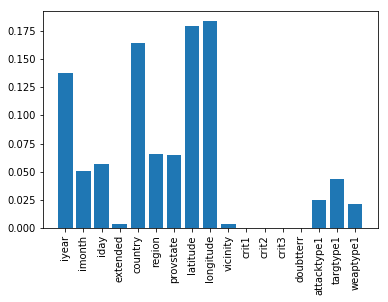

In [247]:
plt.bar(train.columns,rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()